## Zadanie domowe: morfologiczna gra w życie – John Conway

### Wykorzystanie operacji LUT w przekształceniu trafi, nie trafi
  - Szybszą metodą wykonania transformacji trafi, nie trafi może być operacja LUT.
  - Technika polega na zakodowaniu wyników wszystkich interesujących  konfiguracji, a następnie podczas przetwarzania wykorzystania operacji LUT.
  - Dla otoczenia 3x3 możliwe jest 512 różnych konfiguracji.
  - Aby praktycznie zrealizować operacje, każdej konfiguracji należy nadać unikalny indeks. Jedną z możliwości jest pomnożenie elementu strukturalnego przez macierz (mnożenie odpowiednich elementów):
  ```
  [[1, 8,  64],
   [ 2, 16, 128],
   [ 4, 32, 256]]
  ```
  Przykładowo elementowi:
  ```
  [[1, 1, 0],
   [ 1, 0, 1],
   [ 1, 0, 1]]
  ```
  odpowiada liczba: 1(1) + 2(1) + 4(1) + 8(1) + 128(1) + 256(1) = 399.
  
### Przykład działania metody – detekcja punktów końcowych na obrazie.
  - założenie: punkt końcowy to punkt, który ma dokładnie jednego sąsiada,
  - zdefiniuj funkcję, która jako argument pobiera otoczenie, a zwraca 0 lub 1 w zależności od tego, czy rozpatrywany punkt jest końcowy np. dla sąsiedztwa 3×3 punkt będzie końcowy, jeżeli jest zapalony i ma tylko jednego sąsiada (czyli suma pikseli jest równa 2).
  - wygeneruj przekodowanie LUT.
  - wczytaj obraz szkielet.bmp (należy go przekształcić, aby uzyskać dwuwymiarową tablicę o wartościach 0-1). Wykorzystując wygenerowane przekodowanie LUT wykonaj detekcję zakończeń. Wyświetl obraz oryginalny i po przekodowaniu LUT.


In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

if not os.path.exists("szkielet.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/10_Morphology/szkielet.bmp --no-check-certificate

In [56]:
def is_point_ending(surroundings):
    if np.shape(surroundings) != (3, 3):
        raise Exception("Wrong surroundings size")
    
    return np.count_nonzero(surroundings) == 2 and surroundings[1][1]

In [57]:
def get_surroundings_from_index(index):
    bin_str = bin(index).replace("0b","")[::-1]
    if len(bin_str) != 9:
        bin_str += (9 - len(bin_str)) * '0'
    return [[int(bin_str[0]),int(bin_str[3]),int(bin_str[6])],
            [int(bin_str[1]),int(bin_str[4]),int(bin_str[7])],
            [int(bin_str[2]),int(bin_str[5]),int(bin_str[8])]]

In [58]:
get_surroundings_from_index(399)

[[1, 1, 0], [1, 0, 1], [1, 0, 1]]

In [80]:
def get_index_from_surroundings(surroundings):
    if np.shape(surroundings) != (3, 3):
        raise Exception("Wrong surroundings size")
    
    result = 0
    power = 0
    
    for j in range(3):
        for i in range(3):
            if surroundings[i, j]:
                result += 2**power
            power += 1
    return result

In [81]:
get_index_from_surroundings(np.array([[1, 1, 0], [1, 0, 1], [1, 0, 1]]))

399

In [60]:
lookup_table = np.zeros(512)

for i in range(512):
    surroundings = get_surroundings_from_index(i)
    lookup_table[i] = is_point_ending(surroundings)

In [20]:
skeleton = cv2.imread("szkielet.bmp", cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'szkielet')

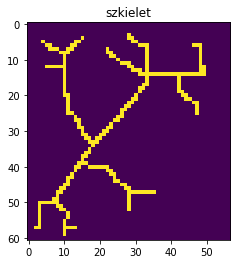

In [63]:
plt.imshow(skeleton)
plt.title('szkielet')

In [64]:
detected_endings = np.zeros(np.shape(skeleton))

In [69]:
skeleton

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [65]:
detected_endings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
for i in range(1, np.shape(skeleton)[0] - 1):
    for j in range(1, np.shape(skeleton)[1] - 1):
        surroundings = skeleton[i-1:i+2,j-1:j+2]
        if lookup_table[get_index_from_surroundings(surroundings)]:
            detected_endings[i, j] = 1

Text(0.5, 1.0, 'Obraz po przekodowaniu LUT')

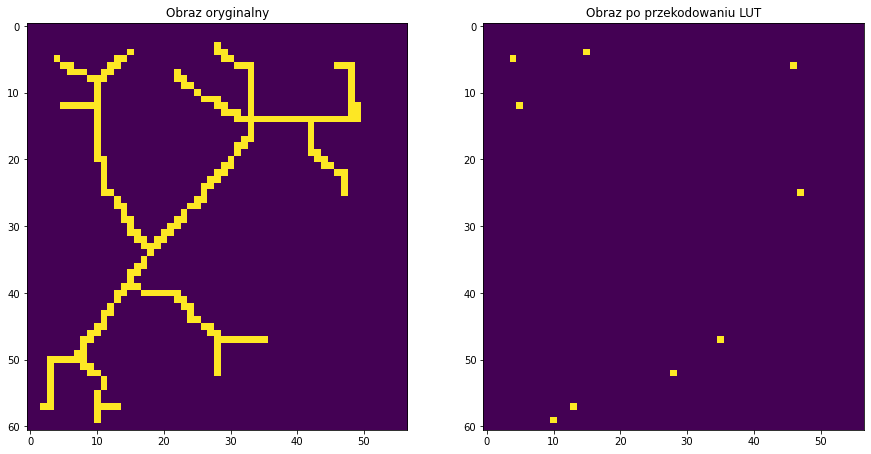

In [86]:
fig, plot = plt.subplots(1, 2)
fig.set_size_inches(15, 15)

plot[0].imshow(skeleton)
plot[0].set_title('Obraz oryginalny')

plot[1].imshow(detected_endings)
plot[1].set_title('Obraz po przekodowaniu LUT')

### Gra w życie

Reguły gry w życie:
  - każdy piksel biały, który ma dwóch lub trzech sąsiadów (białych) przeżywa,
  - każdy piksel biały, który ma 0,1 lub więcej niż trzech sąsiadów (białych) nie przeżywa (głód lub przeludnienie),
  - jeżeli jakieś pole (czarne) sąsiaduje dokładnie z trzema pikselami białymi, to na tym polu ,,rodzi'' się nowy piksel biały.

Zadanie:
  - za pomocą mechanizmu LUT (opisanego wcześniej) należy zaimplementować morfologiczną gre w życie,
  - najważniejszym elementem jest funkcja opisująca reguły gry,
  - symulacje należny przeprowadzić dla plansz plansza1 oraz plansza2 (zob. komórka poniżej),
  - dobrze jest wykonać kilka iteracji – zobaczyć jak zmienia się kształt,
  - inne ciekawe kształty do znalezienia w internecie.

In [89]:
import numpy as np

plansza1 = np.array([
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	1,	0,	0,	1,	0,	0,	0],
    [0,	0,	0,	1,	1,	1,	1,	0,	0,	0],
    [0,	0,	1,	0,	0,	0,	0,	1,	0,	0],
    [0,	0,	1,	0,	1,	1,	0,	1,	0,	0],
    [0,	0,	1,	0,	0,	0,	0,	1,	0,	0],
    [0,	0,	0,	1,	1,	1,	1,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0]], np.uint8)

plansza2 = np.array([
    [0,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1],
    [0,	0,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1],
    [1,	1,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]], np.uint8)

In [90]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


Text(0.5, 1.0, 'plansza 1')

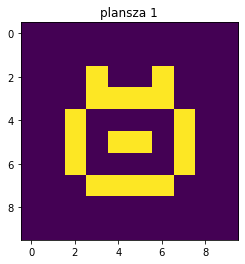

In [91]:
plt.imshow(plansza1)
plt.title('plansza 1')

In [93]:
def is_point_ending_gol(surroundings):
    if np.shape(surroundings) != (3, 3):
        raise Exception("Wrong surroundings size")
        
#     każdy piksel biały, który ma dwóch lub trzech sąsiadów (białych) przeżywa,
    if (np.count_nonzero(surroundings) == 3 or np.count_nonzero(surroundings) == 4) and surroundings[1][1]:
        return True
    
# każdy piksel biały, który ma 0,1 lub więcej niż trzech sąsiadów (białych) nie przeżywa (głód lub przeludnienie)
    if surroundings[1][1]:
        return False
    
# jeżeli jakieś pole (czarne) sąsiaduje dokładnie z trzema pikselami białymi, to na tym polu ,,rodzi'' się nowy piksel biały.
    return np.count_nonzero(surroundings) == 3

In [100]:
gol_lookup_table = np.zeros(512)

for i in range(512):
    surroundings = get_surroundings_from_index(i)
    gol_lookup_table[i] = is_point_ending_gol(surroundings)

In [101]:
def get_next_iteration(board):
    result = np.zeros(np.shape(board))
    
    for i in range(1, np.shape(board)[0] - 1):
        for j in range(1, np.shape(board)[1] - 1):
            surroundings = board[i-1:i+2,j-1:j+2]
            if gol_lookup_table[get_index_from_surroundings(surroundings)]:
                result[i, j] = 1
                
    return result

In [104]:
board1_iterations = [plansza1]

for i in range(9):
    board1_iterations.append(get_next_iteration(board1_iterations[i]))

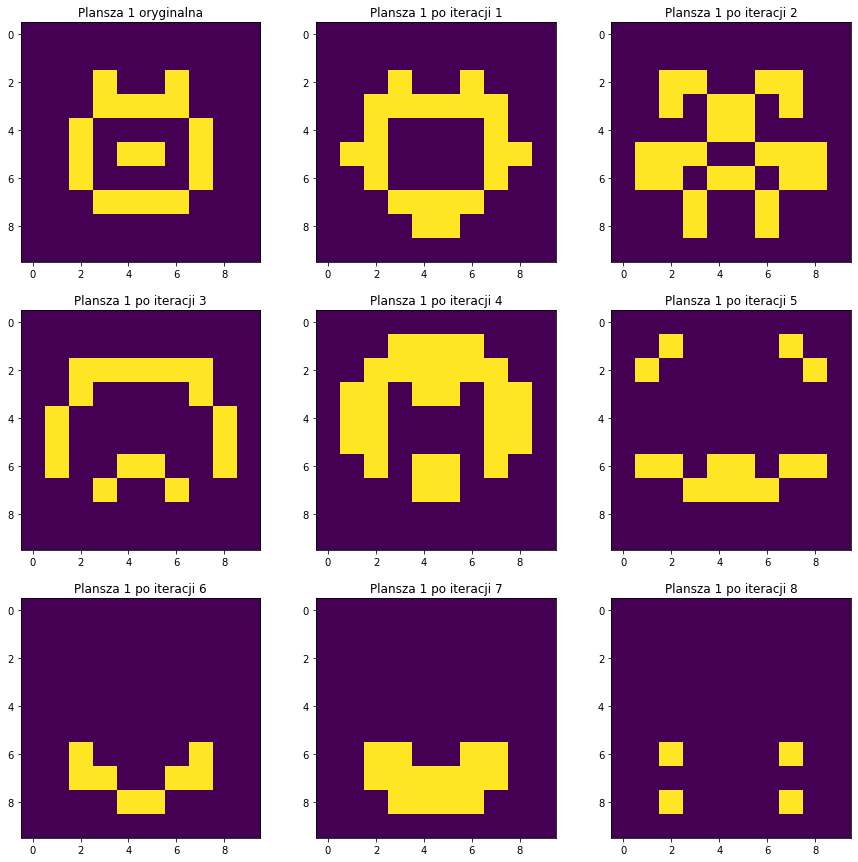

In [122]:
fig, plot = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

plot[0][0].imshow(board1_iterations[0])
plot[0][0].set_title('Plansza 1 oryginalna')
for i in range(3):
    for j in range(3):
        it = i * 3 + j
        if it == 0:
            continue
        plot[i][j].imshow(board1_iterations[it])
        plot[i][j].set_title('Plansza 1 po iteracji ' + str(it))

Text(0.5, 1.0, 'plansza 2')

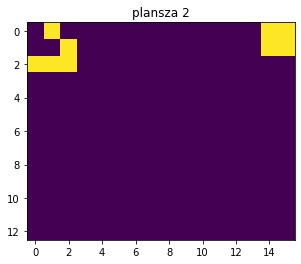

In [123]:
plt.imshow(plansza2)
plt.title('plansza 2')

In [124]:
board2_iterations = [plansza2]

for i in range(9):
    board2_iterations.append(get_next_iteration(board2_iterations[i]))

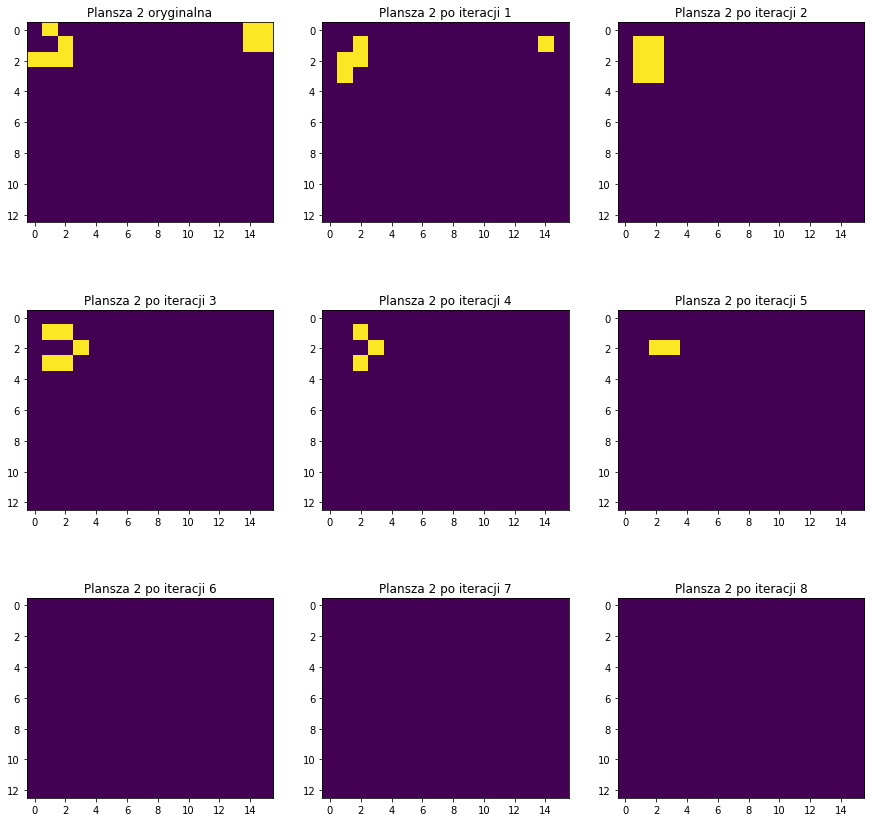

In [125]:
fig, plot = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

plot[0][0].imshow(board2_iterations[0])
plot[0][0].set_title('Plansza 2 oryginalna')
for i in range(3):
    for j in range(3):
        it = i * 3 + j
        if it == 0:
            continue
        plot[i][j].imshow(board2_iterations[it])
        plot[i][j].set_title('Plansza 2 po iteracji ' + str(it))

## Inne plansze

In [128]:
board3 = np.array([[0,0,0,0,0],
         [0,0,0,0,0],
         [0,1,1,1,0],
         [0,0,0,0,0],
         [0,0,0,0,0]])

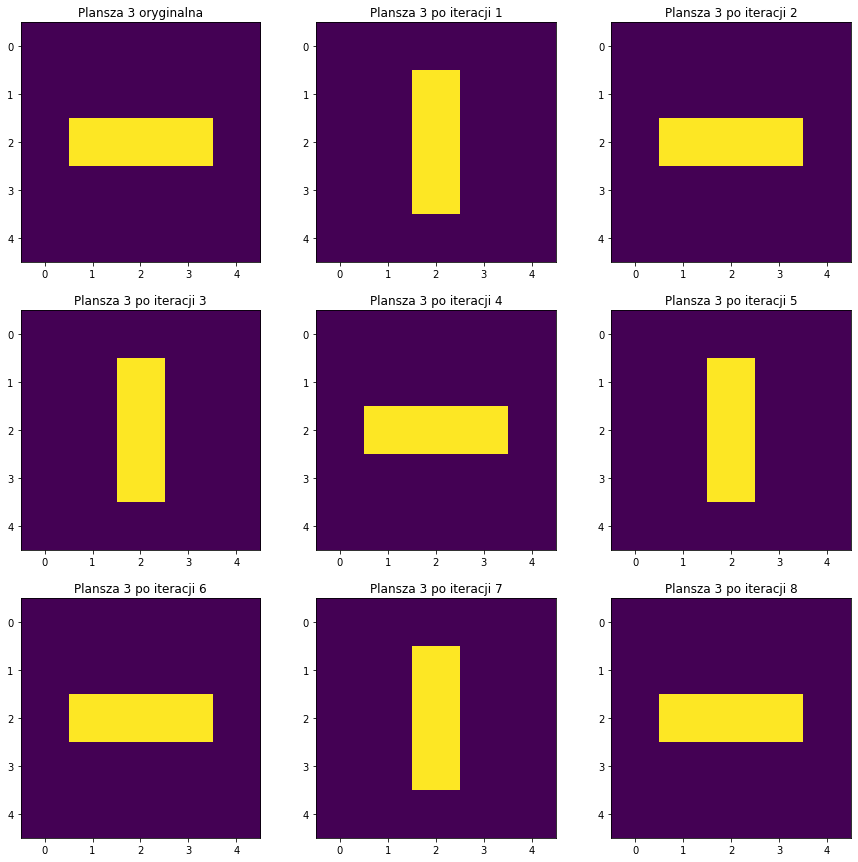

In [137]:
board3_iterations = [board3]

for i in range(9):
    board3_iterations.append(get_next_iteration(board3_iterations[i]))
    
fig, plot = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

plot[0][0].imshow(board3_iterations[0])
plot[0][0].set_title('Plansza 3 oryginalna')
for i in range(3):
    for j in range(3):
        it = i * 3 + j
        if it == 0:
            continue
        plot[i][j].imshow(board3_iterations[it])
        plot[i][j].set_title('Plansza 3 po iteracji ' + str(it))

In [140]:
board4 = np.array([[0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,1,0,0,0,0,0],
                   [0,0,0,0,1,1,1,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0]])

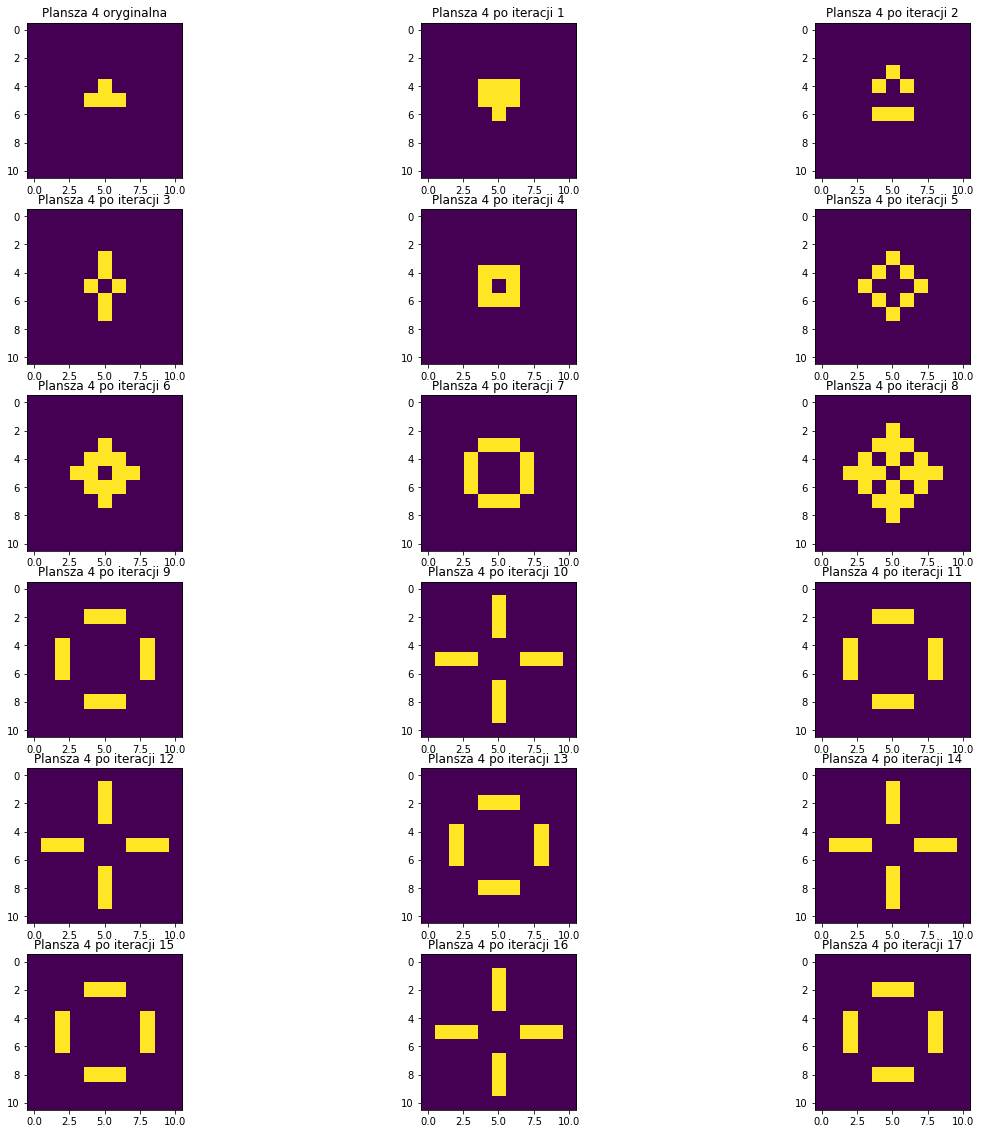

In [141]:
board4_iterations = [board4]

for i in range(18):
    board4_iterations.append(get_next_iteration(board4_iterations[i]))
    
fig, plot = plt.subplots(6, 3)
fig.set_size_inches(20, 20)

plot[0][0].imshow(board4_iterations[0])
plot[0][0].set_title('Plansza 4 oryginalna')
for i in range(6):
    for j in range(3):
        it = i * 3 + j
        if it == 0:
            continue
        plot[i][j].imshow(board4_iterations[it])
        plot[i][j].set_title('Plansza 4 po iteracji ' + str(it))